In [1]:
import matplotlib.pyplot as plt
import numpy as np
import math
import time
import sys
from scipy.spatial.distance import pdist
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from scipy.optimize import fmin

class sshc:
    def __init__(self, N, sig_i = 1, sig_o = 1.5, delta = 0., phi = 0.4, temp = 1):
        #input parameter
        self.N = N
        self.sig_i = sig_i
        self.sig_o = sig_o
        self.delta = delta
        self.phi = phi
        self.temp = temp
        self.flux = []
        self.lbox = 0.0
        
        ############## Initalization #######
        boxL = (N*(4/3)*np.pi*(sig_o**3)/phi)**(1/3)
        self.boxL = boxL
        collect_coor = []
        collect_vec = []
        ini_coor = self.initialize_lattice(N, boxL)
        ini_vec = np.random.normal(0, temp, size=(N, 3))  #avg, std, size
        collect_coor.append(ini_coor)
        collect_vec.append(ini_vec)
        
        self.collect_coor = collect_coor
        self.collect_vec = collect_vec
        self.ini_coor = ini_coor
        self.ini_vec = ini_vec
    
    def dis_mat(self, coor0, coorls):
        A = np.ones((len(coorls), 3))
        A[:, 0] = A[:, 0]*coor0[0]
        A[:, 1] = A[:, 1]*coor0[1]
        A[:, 2] = A[:, 2]*coor0[2]
        B = coorls
        C = B - A
        D = np.square(C)
        E = np.sum(D, axis=1)
        F = np.sqrt(E)
        return F

    def collect_info(self, coorls, sig_i, sig_o):
        # inputting the whole coordinates
        hard = []
        soft = []
        for i in range(len(coorls)):
            ff = self.dis_mat(coorls[i], coorls)
            test_list = list(ff)
            soverlap = [idx for idx, val in enumerate(test_list) if val < 2*self.sig_o and val > 2*self.sig_i]
            hoverlap = [idx for idx, val in enumerate(test_list) if val <= 2*self.sig_i]
            if len(soverlap) > 0:
                for cc in soverlap:
                    if [cc, i] not in soft:
                        soft.append([i, cc])
            if len(hoverlap) > 0:
                for cd in hoverlap:
                    if [cd, i] not in hard:
                        hard.append([i, cd])
        return hard, soft

    def sorted_coor(self, coorls, idxls):
        # Function to be used in ainbox() below
        A = np.zeros((len(idxls), 3))
        for i in range(len(idxls)):
            A[i] = coorls[idxls[i]]
        return A

    def ainbox(self, boxL, sig_i, sig_o, coorls):
        # Function to extract the particles on the edges and calculate their distances
        xval = list(coorls[:,0])
        yval = list(coorls[:,1])
        zval = list(coorls[:,2])
        rsub = self.boxL - self.sig_o
        lsub = self.sig_o
        usub = self.boxL - self.sig_o
        dsub = self.sig_o 
        fsub = self.boxL - self.sig_o
        bsub = self.sig_o
        redge = [idx for idx, val in enumerate(xval) if val <= boxL and val >= rsub]
        ledge = [idx for idx, val in enumerate(xval) if val <= lsub and val >= 0]
        uedge = [idx for idx, val in enumerate(yval) if val <= boxL and val >= usub]
        dedge = [idx for idx, val in enumerate(yval) if val <= dsub and val >= 0]
        fedge = [idx for idx, val in enumerate(zval) if val <= boxL and val >= fsub]
        bedge = [idx for idx, val in enumerate(zval) if val <= bsub and val >= 0]
        hbonding = [] # take all the bonding from all edges
        sbonding = []
        addL = np.zeros((len(ledge), 3))
        addD = np.zeros((len(dedge), 3))
        addB = np.zeros((len(bedge), 3))
        addL[:,0] = 1
        addD[:,1] = 1
        addB[:,2] = 1
        sorted_L = self.sorted_coor(coorls, ledge) + self.boxL*addL
        sorted_D = self.sorted_coor(coorls, dedge) + self.boxL*addD
        sorted_B = self.sorted_coor(coorls, bedge) + self.boxL*addB
        
        temp = len(uedge)
        dif = temp - self.lbox
        self.flux.append([dif])
        self.lbox = temp
        
        
        for i in redge:
            ff = self.dis_mat(coorls[i], sorted_L)
            test_list = list(ff)
            hoverlap = [idx for idx, val in enumerate(test_list) if val <= 2*self.sig_i]
            soverlap = [idx for idx, val in enumerate(test_list) if val < 2*self.sig_o and val > 2*self.sig_i]
            if len(hoverlap) > 0:
                cc = []
                for j in hoverlap:
                    cc.append(ledge[j])
                for j in cc:
                    hbonding.append([i,j])
            if len(soverlap) > 0:
                cc = []
                for j in soverlap:
                    cc.append(ledge[j])
                for j in cc:
                    sbonding.append([i,j])
        for i in uedge:
            ff = self.dis_mat(coorls[i], sorted_D)
            test_list = list(ff)
            hoverlap = [idx for idx, val in enumerate(test_list) if val <= 2*self.sig_i]
            soverlap = [idx for idx, val in enumerate(test_list) if val < 2*self.sig_o and val > 2*self.sig_i]
            if len(hoverlap) > 0:
                cc = []
                for j in hoverlap:
                    cc.append(dedge[j])
                for j in cc:
                    hbonding.append([i,j])
            if len(soverlap) > 0:
                cc = []
                for j in soverlap:
                    cc.append(dedge[j])
                for j in cc:
                    sbonding.append([i,j])
        for i in fedge:
            ff = self.dis_mat(coorls[i], sorted_B)
            test_list = list(ff)
            hoverlap = [idx for idx, val in enumerate(test_list) if val <= 2*self.sig_i]
            soverlap = [idx for idx, val in enumerate(test_list) if val < 2*self.sig_o and val > 2*self.sig_i]
            if len(hoverlap) > 0:
                cc = []
                for j in hoverlap:
                    cc.append(bedge[j])
                for j in cc:
                    hbonding.append([i,j])
            if len(soverlap) > 0:
                cc = []
                for j in soverlap:
                    cc.append(bedge[j])
                for j in cc:
                    sbonding.append([i,j])
        return hbonding, sbonding

    def compute_g2(self, coords, nbins, rmax):
        """
        Given a set of coordinates, compute the pair correlation function g2(r)

        Args:
            coords (np.ndarray): coordinates of the particles
            nbins (int): number of bins to use for the histogram
            rmax (float): maximum distance to consider for the histogram

        Returns:
            bins (np.ndarray): bin edges
            g2 (np.ndarray): pair correlation function
        """
        D = pdist(coords) # computes pairwise distances among all particles
        bins = np.linspace(0, rmax, nbins)
        self.bins = bins

        ## Bin the particles based on their distance
        hist, bins = np.histogram(D, bins=bins)

        ## divide by the volume of the shell
        g2 = hist / (len(coords) * 4*np.pi/3 * (bins[1:]**3 - bins[:-1]**3))

        ## normalize by the average density
        #rho_ave = len(coords) / (4*np.pi/3 * rmax**3)
        g2 = g2 / g2[-3:].mean()
        self.g2 = g2
        return bins, g2

    def initialize_lattice(self, N, boxL):
            """
            Generate a cubic initial conditions mesh within the unit cube

            Returns:
                np.ndarray: coordinates of particles in a three-dimensional mesh
            """
            nx = ny = nz = int(np.ceil(self.N**(1/3)))
            x = np.linspace(0, self.boxL, nx + 1)[:-1]
            y = np.linspace(0, self.boxL, ny + 1)[:-1]
            z = np.linspace(0, self.boxL, nz + 1)[:-1]
            xx, yy, zz = np.meshgrid(x, y, z)
            coords = np.vstack((xx.flatten(), yy.flatten(), zz.flatten())).T

            #coords = np.random.choice(coords, size=self.N, replace=False)
            return coords[:self.N]

    def simulate(self, kk=1000, delta_t=0.05):
        start = time.time()
        natom_pass = []
        k = 0
        self.kk = kk
        while k < kk:
            coorls = self.collect_coor[-1]
            vecls = self.collect_vec[-1]
            hardlsg, softlsg = self.collect_info(coorls, self.sig_i, self.sig_o) # get the bonding without PBC
            hardlsp, softlsp = self.ainbox(self.boxL, self.sig_i, self.sig_o, coorls) # get the bonding on the edges
            hardls = hardlsg + hardlsp
            softls = softlsg + softlsp
            for u in hardls:
                ai, aj = u
                if (vecls[ai]-vecls[aj])@(coorls[ai]-coorls[aj])<0 and np.sqrt(np.sum((coorls[ai]-coorls[aj])**2))<2*self.sig_o:
                    vecls[[ai, aj]] = vecls[[aj, ai]] 
                    continue
                coori = coorls[ai].copy()
                coorj = coorls[aj].copy()
                for i in range(3):
                    if coori[i]-coorj[i]>2*self.sig_o:
                        coorj[i]+=self.boxL
                    if coorj[i]-coori[i]>2*self.sig_o:
                        coori[i]+=self.boxL
                if (vecls[ai]-vecls[aj])@(coori-coorj)<0:
                    vecls[[ai, aj]] = vecls[[aj, ai]] 
            for u in softls:
                ai, aj = u
                if (vecls[ai]-vecls[aj])@(coorls[ai]-coorls[aj])<0 and np.sqrt(np.sum((coorls[ai]-coorls[aj])**2))<2*self.sig_o:
                    if np.random.rand() < self.delta: 
                        vecls[[ai, aj]] = vecls[[aj, ai]]
                        continue
                coori = coorls[ai].copy()
                coorj = coorls[aj].copy()
                for i in range(3):
                    if coori[i]-coorj[i]>2*self.sig_o:
                        coorj[i]+=self.boxL
                    if coorj[i]-coori[i]>2*self.sig_o:
                        coori[i]+=self.boxL
                if (vecls[ai]-vecls[aj])@(coori-coorj)<0:
                    if np.random.rand() < self.delta: 
                        vecls[[ai, aj]] = vecls[[aj, ai]] 
            coorls = coorls + vecls*delta_t
            coorlsp = coorls%self.boxL # for PBC
            pp = coorlsp - coorls
            psum = np.sum(pp, axis=1)
            cnt_n0 = np.count_nonzero(psum)
            natom_pass.append(cnt_n0/6) # average to each wall
            self.collect_coor.append(coorlsp)
            self.collect_vec.append(vecls)
            k = k + 1

        end = time.time()
        timediff = end - start
        print('Computing time of {} particles for {} steps: {}s'.format(self.N, kk, timediff))
    
    def histfunc(self, nstep = 10, nbins = 100, rnolmax = 4):
        self.nbins = nbins
        nslice = int(self.kk / nstep)
        rmax = rnolmax * self.sig_o
        self.rmax = rmax
        histsum = np.zeros(nbins-1)
        sample = range(20, nslice)
        
        for i in sample:
            coords = self.collect_coor[(i+1) * nstep]
            self.bins, hist = self.compute_g2(coords, nbins = nbins, rmax = rmax)
            histsum += hist
        self.normbins = self.bins[:-1] / self.sig_o
        self.histavg = histsum / len(sample)
    
    def findmin(self, fitdegree = 5):
        rstart = 2 * self.sig_o
        startnum = int((rstart / self.rmax) * self.nbins)
        rfrange = self.normbins[startnum:]
        grfrange = self.histavg[startnum:]
        
        polynomial_features = PolynomialFeatures(degree = fitdegree)
        linear_regression = LinearRegression()
        pipeline = Pipeline([("pf", polynomial_features), ("lr", linear_regression)])
        pipeline.fit(rfrange[:, np.newaxis], grfrange)
        def f(x):
            xlist = x
            xlist = np.array(xlist)
            xlist.flatten()
            return pipeline.predict(xlist[:, np.newaxis])
        self.pipeline = pipeline
        return fmin(f, 3, disp = 0)[0]

# 1 simulation 

In [21]:
a = sshc(N = 216, sig_i = 1, sig_o = 2, delta = 0.3, phi = 0.45, temp = 3)
a.simulate(kk = 2000, delta_t = 0.05)
np.save('my_list.npy', a.flux)

Computing time of 216 particles for 2000 steps: 40.81348204612732s


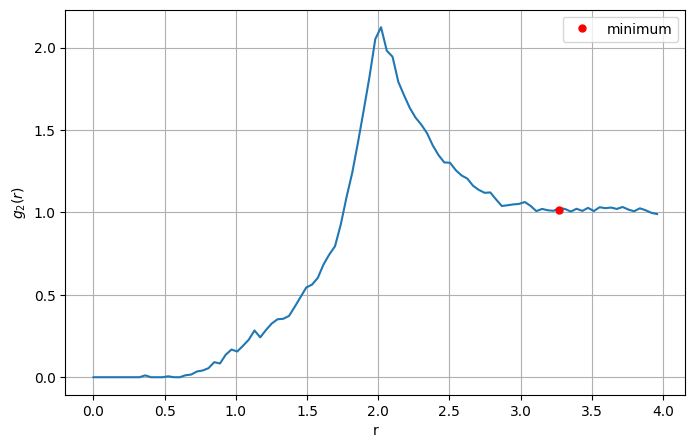

In [22]:
plt.figure(figsize = (8, 5))
a.histfunc(nstep = 10, nbins = 100, rnolmax = 4)
plt.plot(a.normbins, a.histavg)
grmin = a.findmin(fitdegree = 6)
plt.plot(grmin, a.pipeline.predict([[grmin,]]), 'r.', markersize=10, label = "minimum")
plt.legend()
plt.grid()
plt.xlabel(r'r')
plt.ylabel(r'$g_2(r)$')
plt.show()

In [33]:
## Make an interactive video
from ipywidgets import interact
import ipywidgets as widgets


def plotter(i):
    coords = a.collect_coor[i]
    fig = plt.figure(figsize=(8,8))
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(coords[:, 0], coords[:, 1], coords[:, 2], c='b', marker='o', s=1000, alpha=0.2)
    ax.set_zlim(0, a.boxL)
    plt.xlim([0, a.boxL])
    plt.ylim([0, a.boxL])
    
    plt.show()

interact(
    plotter, 
    i=widgets.IntSlider(min=0, max=len(a.collect_coor)-1, step=1, value=0)
)



interactive(children=(IntSlider(value=0, description='i', max=2000), Output()), _dom_classes=('widget-interact…

<function __main__.plotter(i)>

# n simulation

Computing time of 1000 particles for 2000 steps: 280.02233505249023s
Computing time of 1000 particles for 2000 steps: 452.8393213748932s
Computing time of 1000 particles for 2000 steps: 455.8747007846832s
Computing time of 1000 particles for 2000 steps: 449.2391700744629s
Computing time of 1000 particles for 2000 steps: 451.2431118488312s
Computing time of 1000 particles for 2000 steps: 455.0682940483093s
Computing time of 1000 particles for 2000 steps: 455.84416913986206s
Computing time of 1000 particles for 2000 steps: 457.99755239486694s
Computing time of 1000 particles for 2000 steps: 459.7468972206116s
Computing time of 1000 particles for 2000 steps: 461.6885018348694s
Computing time of 1000 particles for 2000 steps: 465.20769214630127s
Computing time of 1000 particles for 2000 steps: 468.73112058639526s
Computing time of 1000 particles for 2000 steps: 471.2625162601471s
Computing time of 1000 particles for 2000 steps: 476.3626582622528s
Computing time of 1000 particles for 2000 s

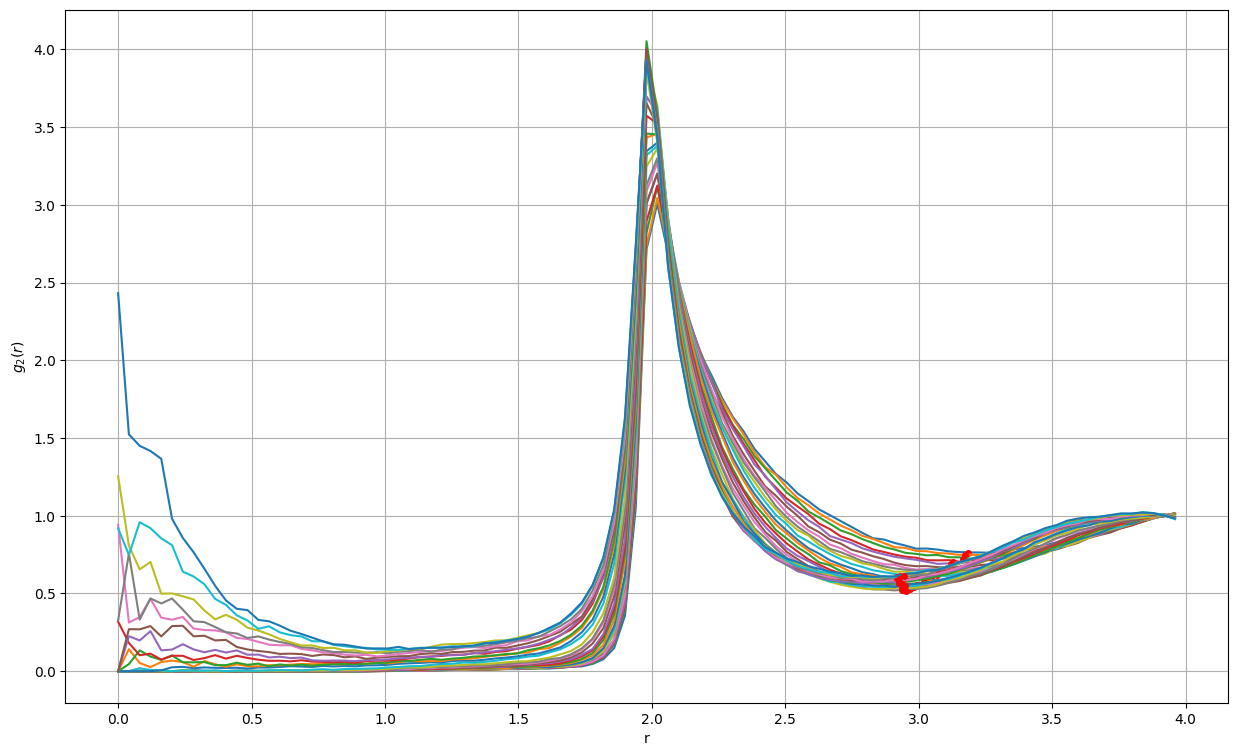

In [4]:
alist = []
grmin = []
plt.figure(figsize = (15, 9))
for i in range(31):
    alist.append(sshc(N = 1000, sig_i = 1, sig_o = 2, delta = 0.5, phi = 0.4 + 0.01 * i, temp = 1))
    alist[i].simulate(kk = 2000, delta_t = 0.05)
    np.save(f'Flux_{i}.npy', alist[i].flux)
    alist[i].histfunc(nstep = 10, nbins = 100, rnolmax = 4)
    plt.plot(alist[i].normbins, alist[i].histavg)
    grmin.append(alist[i].findmin(fitdegree = 6))
    plt.plot(grmin[i], alist[i].pipeline.predict([[grmin[i],]]), 'r.', markersize=8)
plt.grid()
plt.legend()
plt.xlabel(r'r')
plt.ylabel(r'$g_2(r)$')
plt.show()

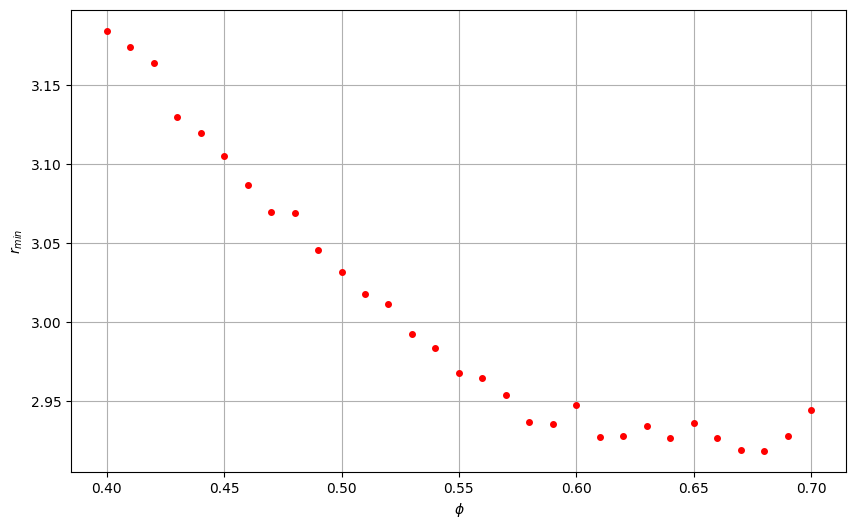

In [5]:
plt.figure(figsize = (10,6))
for i in range(len(alist)):
    plt.plot(alist[i].phi, grmin[i], 'r.', markersize=8)
plt.grid()
plt.legend()
plt.xlabel(r'$\phi$')
plt.ylabel(r'$r_{min}$')
plt.show()

Computing time of 1000 particles for 2000 steps: 247.06689071655273s
Computing time of 1000 particles for 2000 steps: 248.78033757209778s
Computing time of 1000 particles for 2000 steps: 250.34575080871582s
Computing time of 1000 particles for 2000 steps: 253.74446892738342s
Computing time of 1000 particles for 2000 steps: 247.79104495048523s
Computing time of 1000 particles for 2000 steps: 246.13423800468445s
Computing time of 1000 particles for 2000 steps: 242.353040933609s
Computing time of 1000 particles for 2000 steps: 246.4488935470581s
Computing time of 1000 particles for 2000 steps: 252.41490840911865s
Computing time of 1000 particles for 2000 steps: 253.91785526275635s
Computing time of 1000 particles for 2000 steps: 254.89768981933594s
Computing time of 1000 particles for 2000 steps: 256.0430362224579s
Computing time of 1000 particles for 2000 steps: 257.35451436042786s
Computing time of 1000 particles for 2000 steps: 258.96220111846924s
Computing time of 1000 particles for 2

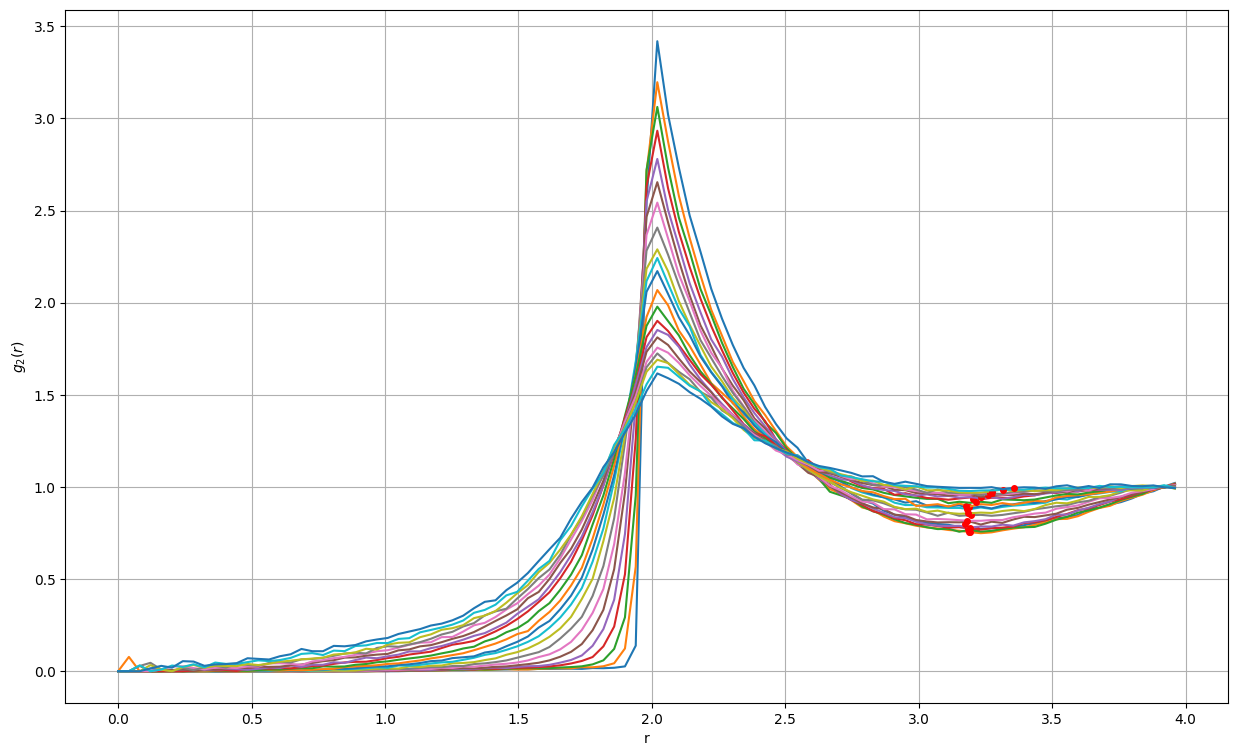

In [3]:
blist = []
grminb = []
plt.figure(figsize = (15, 9))
for i in range(21):
    blist.append(sshc(N = 1000, sig_i = 1, sig_o = 2, delta = 0.5, phi = 0.4, temp = 0.3 + 0.3 * i))
    blist[i].simulate(kk = 2000, delta_t = 0.05)
    blist[i].histfunc(nstep = 10, nbins = 100, rnolmax = 4)
    np.save(f'temp_{i}.npy', blist[i].flux)
    plt.plot(blist[i].normbins, blist[i].histavg)
    grminb.append(blist[i].findmin(fitdegree = 6))
    plt.plot(grminb[i], blist[i].pipeline.predict([[grminb[i],]]), 'r.', markersize=8)
plt.grid()
plt.legend()
plt.xlabel(r'r')
plt.ylabel(r'$g_2(r)$')
plt.show()

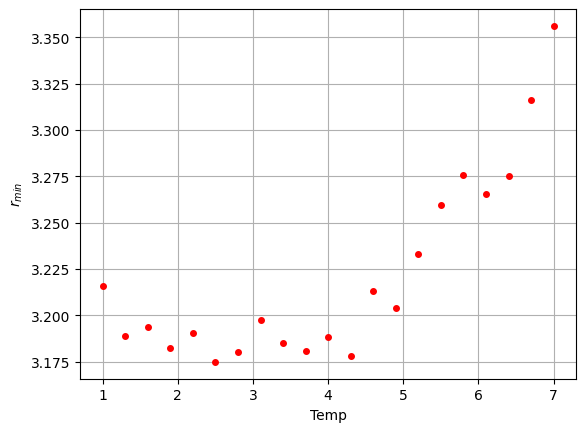

In [4]:
for i in range(len(blist)):
    plt.plot(1 + 0.3 * i, grminb[i], 'r.', markersize=8)
plt.grid()
plt.xlabel(r'Temp')
plt.ylabel(r'$r_{min}$')
plt.show()

Computing time of 1000 particles for 2000 steps: 275.48777198791504s
Computing time of 1000 particles for 2000 steps: 260.6124827861786s
Computing time of 1000 particles for 2000 steps: 254.79721474647522s
Computing time of 1000 particles for 2000 steps: 250.76017546653748s
Computing time of 1000 particles for 2000 steps: 248.72438263893127s
Computing time of 1000 particles for 2000 steps: 246.4127070903778s
Computing time of 1000 particles for 2000 steps: 244.45973753929138s
Computing time of 1000 particles for 2000 steps: 246.50794863700867s
Computing time of 1000 particles for 2000 steps: 249.9499170780182s
Computing time of 1000 particles for 2000 steps: 247.06330013275146s
Computing time of 1000 particles for 2000 steps: 246.46660804748535s


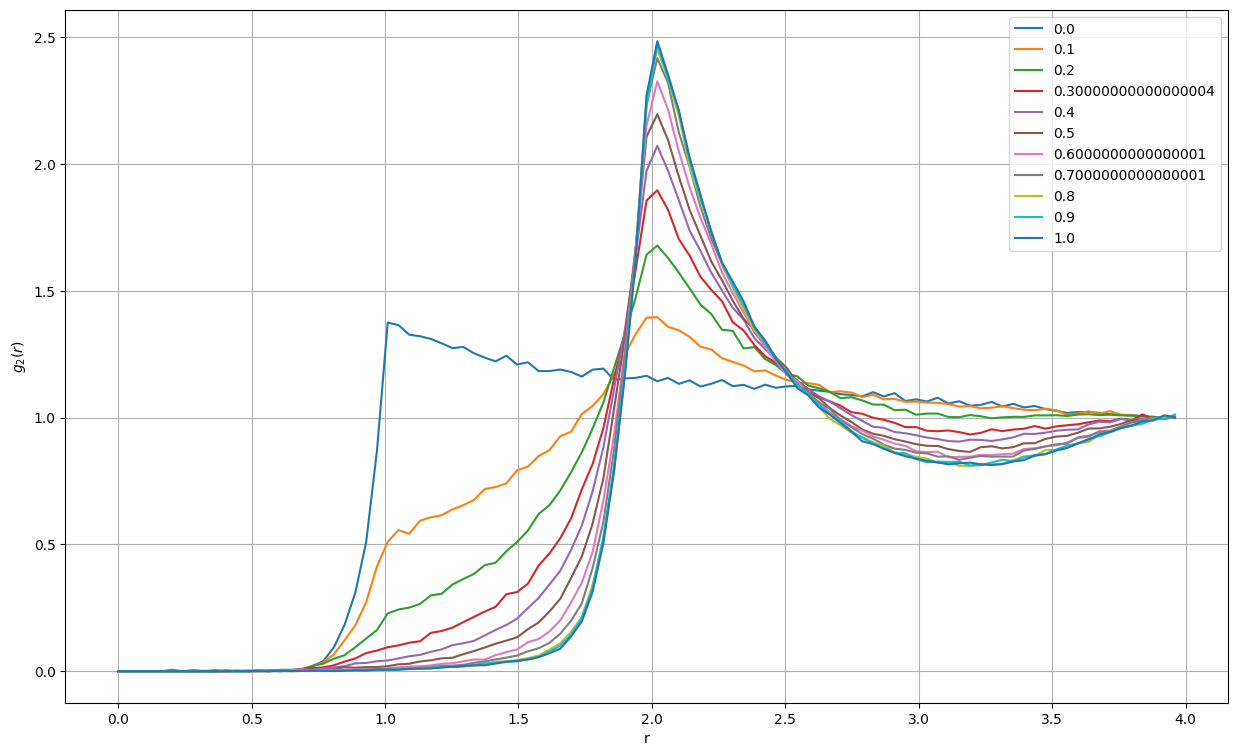

In [2]:
blist = []
grminb = []
plt.figure(figsize = (15, 9))
for i in range(11):
    blist.append(sshc(N = 1000, sig_i = 1, sig_o = 2, delta = 0.0 + 0.1 * i, phi = 0.4, temp = 3.0))
    blist[i].simulate(kk = 2000, delta_t = 0.05)
    blist[i].histfunc(nstep = 10, nbins = 100, rnolmax = 4)
    np.save(f'temp_{i}.npy', blist[i].flux)
    la = str(0.0 + 0.1 * i)
    plt.plot(blist[i].normbins, blist[i].histavg,label=la)
    grminb.append(blist[i].findmin(fitdegree = 10))
#    plt.plot(grminb[i], blist[i].pipeline.predict([[grminb[i],]]), 'r.', markersize=8)
plt.grid()
plt.legend()
plt.xlabel(r'r')
plt.ylabel(r'$g_2(r)$')
plt.show()

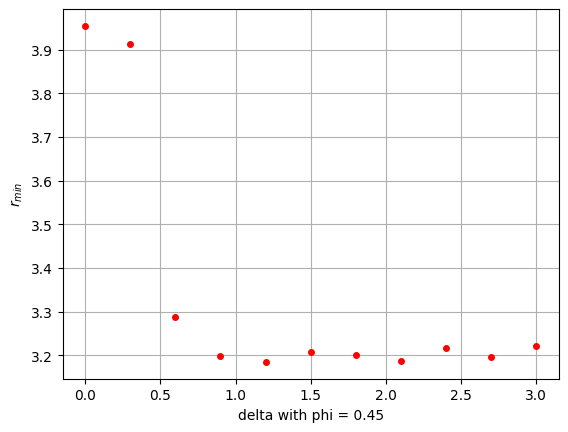

In [3]:
for i in range(len(blist)):
    plt.plot(0.0 + 0.3*i, grminb[i], 'r.', markersize=8)
    print ()
plt.grid()
plt.xlabel(r'delta with phi = 0.45')
plt.ylabel(r'$r_{min}$')
plt.show()

Computing time of 1000 particles for 2000 steps: 319.0646023750305s
Computing time of 1000 particles for 2000 steps: 294.93458223342896s
Computing time of 1000 particles for 2000 steps: 289.37097096443176s
Computing time of 1000 particles for 2000 steps: 286.4619002342224s
Computing time of 1000 particles for 2000 steps: 285.2433807849884s
Computing time of 1000 particles for 2000 steps: 282.7470009326935s
Computing time of 1000 particles for 2000 steps: 281.8788459300995s
Computing time of 1000 particles for 2000 steps: 281.4214389324188s
Computing time of 1000 particles for 2000 steps: 281.21886944770813s
Computing time of 1000 particles for 2000 steps: 280.9103329181671s
Computing time of 1000 particles for 2000 steps: 280.9353678226471s


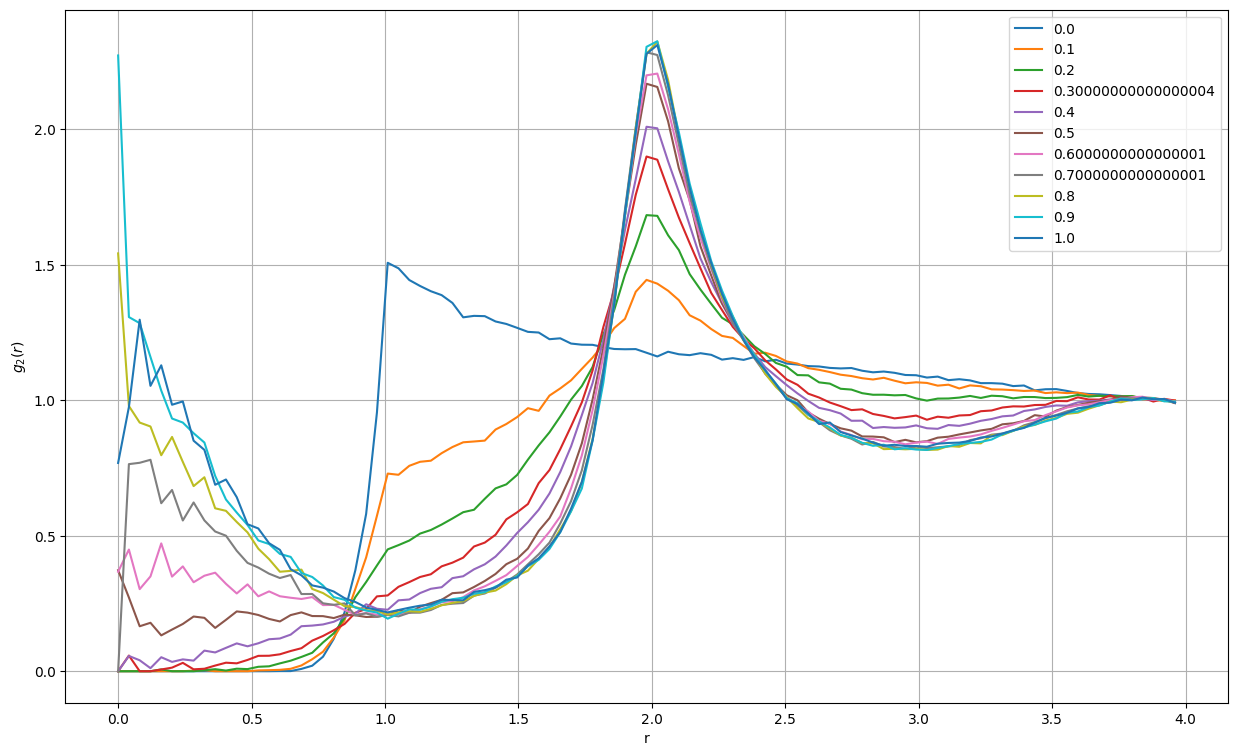

In [4]:
blist = []
grminb = []
plt.figure(figsize = (15, 9))
for i in range(11):
    blist.append(sshc(N = 1000, sig_i = 1, sig_o = 2, delta = 0.0 + 0.1 * i, phi = 0.6, temp = 3.0))
    blist[i].simulate(kk = 2000, delta_t = 0.05)
    blist[i].histfunc(nstep = 10, nbins = 100, rnolmax = 4)
    np.save(f'temp_{i}.npy', blist[i].flux)
    la = str(0.0 + 0.1 * i)
    plt.plot(blist[i].normbins, blist[i].histavg,label=la)
    grminb.append(blist[i].findmin(fitdegree = 10))
#    plt.plot(grminb[i], blist[i].pipeline.predict([[grminb[i],]]), 'r.', markersize=8)
plt.grid()
plt.legend()
plt.xlabel(r'r')
plt.ylabel(r'$g_2(r)$')
plt.show()

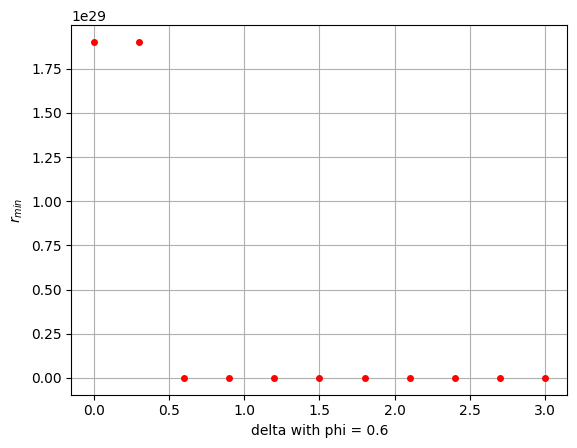

In [5]:
for i in range(len(blist)):
    plt.plot(0.0 + 0.3*i, grminb[i], 'r.', markersize=8)
    print ()
plt.grid()
plt.xlabel(r'delta with phi = 0.6')
plt.ylabel(r'$r_{min}$')
plt.show()

Computing time of 1000 particles for 2000 steps: 525.881422996521s
Computing time of 1000 particles for 2000 steps: 490.33112025260925s
Computing time of 1000 particles for 2000 steps: 481.7438669204712s
Computing time of 1000 particles for 2000 steps: 478.71118569374084s
Computing time of 1000 particles for 2000 steps: 474.17544889450073s
Computing time of 1000 particles for 2000 steps: 473.537478685379s
Computing time of 1000 particles for 2000 steps: 470.4119153022766s
Computing time of 1000 particles for 2000 steps: 469.2724633216858s
Computing time of 1000 particles for 2000 steps: 471.31394720077515s
Computing time of 1000 particles for 2000 steps: 468.6272122859955s
Computing time of 1000 particles for 2000 steps: 463.03553318977356s


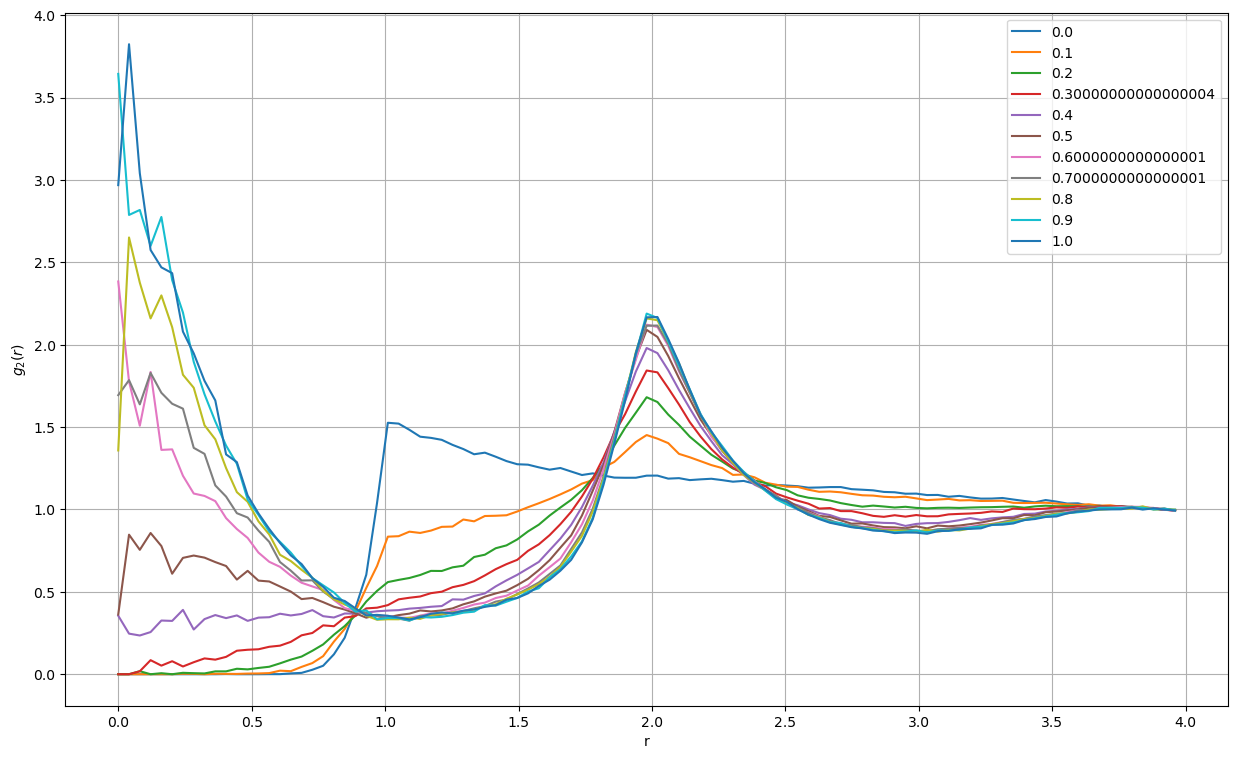

In [2]:
blist = []
grminb = []
plt.figure(figsize = (15, 9))
for i in range(11):
    blist.append(sshc(N = 1000, sig_i = 1, sig_o = 2, delta = 0.0 + 0.1 * i, phi = 0.7, temp = 3.0))
    blist[i].simulate(kk = 2000, delta_t = 0.05)
    blist[i].histfunc(nstep = 10, nbins = 100, rnolmax = 4)
    np.save(f'temp_{i}.npy', blist[i].flux)
    la = str(0.0 + 0.1 * i)
    plt.plot(blist[i].normbins, blist[i].histavg,label=la)
    grminb.append(blist[i].findmin(fitdegree = 10))
#    plt.plot(grminb[i], blist[i].pipeline.predict([[grminb[i],]]), 'r.', markersize=8)
plt.grid()
plt.legend()
plt.xlabel(r'r')
plt.ylabel(r'$g_2(r)$')
plt.show()

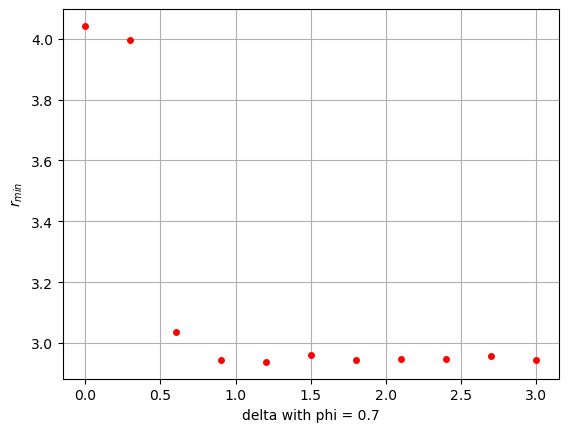

In [3]:
for i in range(len(blist)):
    plt.plot(0.0 + 0.3*i, grminb[i], 'r.', markersize=8)
    print ()
plt.grid()
plt.xlabel(r'delta with phi = 0.7')
plt.ylabel(r'$r_{min}$')
plt.show()